In [82]:
#%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

In [194]:
import numpy as np
import pandas as pd
import scipy.stats as stats

In [3]:
import datetime as dt
from datetime import date, timedelta

# Reflect Tables into SQLAlchemy ORM

In [227]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, extract, inspect

In [5]:
# Create Engine
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [6]:
# reflect an existing database into a new model
station_df = pd.read_sql("SELECT * FROM Station", conn)
# reflect the tables
station_df

,id,station,name,latitude,longitude,elevation
0,1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
1,2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
2,3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
3,4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
4,5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
5,6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
7,8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
8,9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [7]:
# reflect an existing database into a new model
measurement_df = pd.read_sql("SELECT * FROM Measurement", engine)
# reflect the tables
print(measurement_df.shape)
measurement_df.tail(1)

(19550, 5)


,id,station,date,prcp,tobs
19549,19550,USC00516128,2017-08-23,0.45,76.0


In [8]:
# We can view all of the classes that automap found
Base = automap_base()
Base.prepare(engine, reflect=True)
Base.classes.keys()

['measurement', 'station']

In [9]:
# Save references to table 'measurement' 
Measurement = Base.classes.measurement
# Create our session (link) from Python to the DB
session = Session(engine)
# Check database
Base.metadata.tables

immutabledict({'measurement': Table('measurement', MetaData(bind=None), Column('id', INTEGER(), table=<measurement>, primary_key=True, nullable=False), Column('station', TEXT(), table=<measurement>), Column('date', TEXT(), table=<measurement>), Column('prcp', FLOAT(), table=<measurement>), Column('tobs', FLOAT(), table=<measurement>), schema=None), 'station': Table('station', MetaData(bind=None), Column('id', INTEGER(), table=<station>, primary_key=True, nullable=False), Column('station', TEXT(), table=<station>), Column('name', TEXT(), table=<station>), Column('latitude', FLOAT(), table=<station>), Column('longitude', FLOAT(), table=<station>), Column('elevation', FLOAT(), table=<station>), schema=None)})

In [10]:
# Display the row's columns and data in dictionary format
first_row = session.query(Measurement).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237f1652f88>,
 'date': '2010-01-01',
 'tobs': 65.0,
 'id': 1,
 'station': 'USC00519397',
 'prcp': 0.08}

In [11]:
# Save references to table 'station'
Station = Base.classes.station
# Create our session (link) from Python to the DB
session = Session(engine)
# Display the row's columns and data in dictionary format
first_row = session.query(Station).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x237f1715448>,
 'station': 'USC00519397',
 'latitude': 21.2716,
 'elevation': 3.0,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US'}

# Step 1 - Climate Analysis and Exploration

## Precipitation Analysis

In [108]:
## Design a query to retrieve the last 12 months of precipitation data and plot the results

# Calculate the date 1 year ago from the last data point in the database
LastDate = (session.query(func.max(Measurement.date)).first())
PrevYrDate = dt.datetime.strptime(LastDate[0], '%Y-%m-%d') - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
results =   session.query(Measurement.date, Measurement.station, Measurement.prcp).\
            filter(Measurement.date >= PrevYrDate).all()

# Save the query results as a Pandas DataFrame and set the index to the date column
LastYrPrcp_df = pd.DataFrame(results)
LastYrPrcp_df['date'] = LastYrPrcp_df['date'].astype('datetime64[ns]')

# Sort the dataframe by date
LastYrPrcp_df.sort_values(by="date", inplace=True)
print(LastYrPrcp_df.shape)
LastYrPrcp_df.head(2)

(2223, 3)


,date,station,prcp
0,2016-08-24,USC00519397,0.08
1006,2016-08-24,USC00517948,NaN


In [109]:
# Use Pandas to calcualte the summary statistics for the precipitation data
LastYrPrcp_df.describe()

,prcp
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


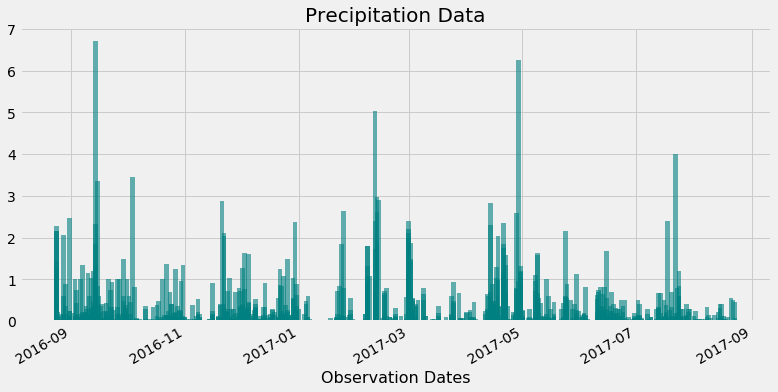

In [235]:
# Use Pandas Plotting with Matplotlib to plot the data
fig, ax = plt.subplots(figsize=(12, 6)) 

plt.bar(LastYrPrcp_df['date'], LastYrPrcp_df['prcp'], color="teal", align="center",alpha=.6, width = 2.5)

myFmt = DateFormatter("%d %m %y")
fig.autofmt_xdate()

plt.title("Precipitation Data", fontsize=20)
plt.xlabel("Observation Dates", fontsize=16)
plt.savefig("Graphs/Unit10-1.png")
plt.show()

## Stations Analysis

In [106]:
# Design a query to show how many stations are available in this dataset?
NumberofStation = session.query(Station).count()
print(f"There are {NumberofStation} Weather Stations")

There are 9 Weather Stations


In [107]:
station_df = pd.read_sql(session.query(Station).statement, session.bind).set_index("id") 
station_df

,station,name,latitude,longitude,elevation
id,,,,,
1,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0
2,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00517948,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00518838,"UPPER WAHIAWA 874.3, HI US",21.49920,-158.01110,306.6
6,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
7,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
8,USC00511918,"HONOLULU OBSERVATORY 702.2, HI US",21.31520,-157.99920,0.9
9,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4


In [33]:
# What are the most active stations? (i.e. what stations have the most rows)?
# List the stations and the counts in descending order.
results =   session.query(Measurement.station, func.count(Measurement.station)).\
            group_by(Measurement.station).\
            order_by(func.count(Measurement.station).desc()).all()
MostActive_df = pd.DataFrame(results, columns =['station', 'no_of rows']) 

MostActice = results[0][0]
print(f"The most active station is {MostActice} Weather Station")

MostActive_df.head(1)

The most active station is USC00519281 Weather Station


,station,no_of rows
0,USC00519281,2772


In [42]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?
ActvStat =   session.query(Measurement.station, func.min(Measurement.tobs),\
                           func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
            filter(Measurement.station == MostActice).first()

print(f"Temperature data from {ActvStat[0]} : Min Temp = {ActvStat[1]}, Avg Temp = {ActvStat[2]}, Max Temp = {ActvStat[3]}")

Temperature data from USC00519281 : Min Temp = 54.0, Avg Temp = 71.66378066378067, Max Temp = 85.0


In [48]:
# Choose the station with the highest number of temperature observations.
MaxTemp = (session.query(Measurement.station, func.max(Measurement.tobs)).first())
HotStation = MaxTemp[0]

# Query the last 12 months of temperature observation data for this station 
HotStTemp_df = pd.read_sql(f"SELECT Measurement.date, Measurement.tobs FROM Measurement WHERE (Measurement.date >'{PrevYrDate}' and Measurement.station == '{HotStation}' )", conn)
HotStTemp_df.set_index("date", inplace=True)
HotStTemp_df.head(1)

,tobs
date,
2016-08-24,79.0


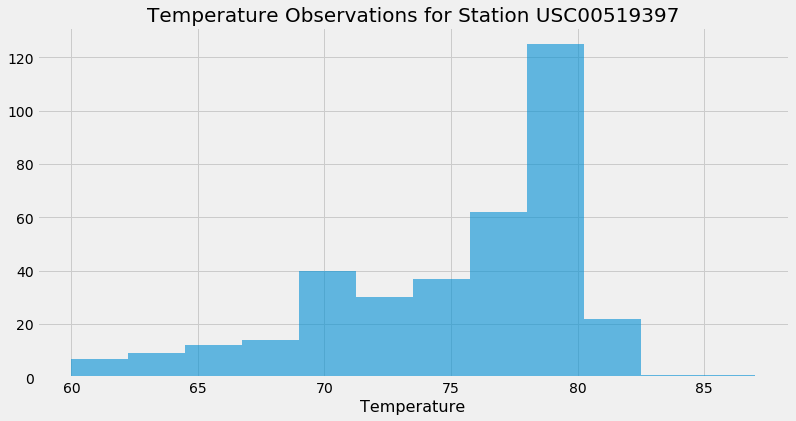

In [236]:
#plot the results as a histogram
fig, ax = plt.subplots(figsize=(12, 6)) 
plt.hist(HotStTemp_df['tobs'], bins=12, alpha=.6)
plt.title("Temperature Observations for Station " + HotStation, fontsize=20)
plt.xlabel("Temperature", fontsize=16)
plt.savefig("Graphs/Unit10-2.png")
plt.show()

# Step 2 - Climate App

Design a Flask API based on the queries that you have just developed.
- Use Flask to create your routes.
- You will need to join the station and measurement tables for some of the queries.
- Use Flask jsonify to convert your API data into a valid JSON response object.

# Bonus Challenge Assignment

## Temperature Analysis 1

Hawaii is reputed to enjoy mild weather all year. Is there a meaningful difference between the temperature in, for example, June and December?<br>

Identify the average temperature in June at all stations across all available years in the dataset. Do the same for December temperature.<br>

Use the t-test to determine whether the difference in the means, if any, is statistically significant. Will you use a paired t-test, or an unpaired t-test? Why?

In [190]:
# Create temperature list for June and December
June_temp_df = pd.DataFrame(session.query(Measurement.tobs).\
                    filter(extract('month', Measurement.date)==6).all(), columns =['Jun temp'])
Dec_temp_df = pd.DataFrame(session.query(Measurement.tobs).\
                    filter(extract('month', Measurement.date)==12).all(), columns =['Dec temp'])

In [192]:
Jun_Dec_stat = June_temp_df.describe() 
Jun_Dec_stat['Dec temp'] = Dec_temp_df.describe() 
Jun_Dec_stat

,Jun temp,Dec temp
count,1700.000000,1517.000000
mean,74.944118,71.041529
std,3.257417,3.745920
min,64.000000,56.000000
25%,73.000000,69.000000
50%,75.000000,71.000000
75%,77.000000,74.000000
max,85.000000,83.000000


In [214]:
# Calculate Independent (Two Sample) T-Test
pvalue = stats.ttest_ind(June_temp_df, Dec_temp_df, equal_var=False)[1][0]

if pvalue < 0.05:
    print(f"June and December weather are significatly different because the pvalue of {pvalue} is smaller than 0.05")
else:
    print(f"June and December weather are NOT different because the pvalue of {pvalue} is larger than 0.05")


June and December weather are significatly different because the pvalue of 4.193529835915755e-187 is smaller than 0.05


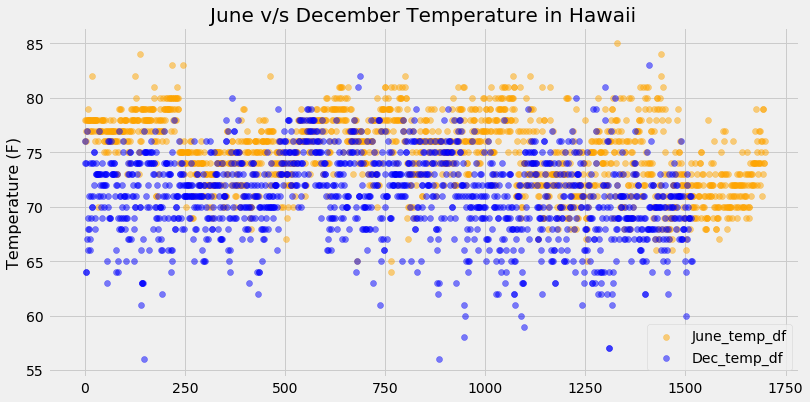

In [239]:
# Scatter Plot of Data
fig, ax = plt.subplots(figsize=(12, 6))

plt.scatter(range(len(June_temp_df)), June_temp_df, label="June_temp_df", color="orange",alpha=0.5)
plt.scatter(range(len(Dec_temp_df)), Dec_temp_df, label="Dec_temp_df", color="blue", alpha=0.5)

plt.title("June v/s December Temperature in Hawaii", fontsize=20)
plt.ylabel("Temperature (F)", fontsize=16)
plt.legend()
plt.savefig("Graphs/Unit10-4.png")

plt.show()

In [238]:
June_avg =   session.query(Measurement.station, func.avg(Measurement.tobs)).\
                filter(extract('month', Measurement.date)==6).\
                group_by(Measurement.station).all()
June_avg_df = pd.DataFrame(June_avg, columns =['station', 'Jun avg temp'])

Dec_avg =   session.query(Measurement.station, func.avg(Measurement.tobs)).\
                filter(extract('month', Measurement.date)==12).\
                group_by(Measurement.station).all()
Dec_avg_df = pd.DataFrame(Dec_avg, columns =['station', 'Dec avg temp'])

Jun_Dec_df = pd.merge(June_avg_df,Dec_avg_df, how="left", on=["station", "station"])

Jun_Dec_df

,station,Jun avg temp,Dec avg temp
0,USC00511918,74.139394,69.684211
1,USC00513117,74.050847,71.069444
2,USC00514830,76.005376,73.224719
3,USC00516128,71.937220,69.291262
4,USC00517948,76.655405,71.834862
5,USC00518838,73.394737,72.421053
6,USC00519281,73.271186,69.903226
7,USC00519397,77.559322,71.109524
8,USC00519523,76.668103,72.433333


## Temperature Analysis 2

### Trip Average Temperature
The starter notebook contains a function called calc_temps that will accept a start date and end date in the format %Y-%m-%d. The function will return the minimum, average, and maximum temperatures for that range of dates.<br>
Use the calc_temps function to calculate the min, avg, and max temperatures for your trip using the matching dates from the previous year (i.e., use "2017-01-01" if your trip start date was "2018-01-01").

In [155]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

[(62.0, 69.57142857142857, 74.0)]


In [56]:
# Set the start and end date of the trip
Trip_Start_Date = '2021-10-15'
Trip_End_Date = '2021-11-05'

In [124]:
# calculate the corresponding date (in the data time frame) of the planned trip date
PrevYr_trip_start = dt.datetime.strptime(Trip_Start_Date, '%Y-%m-%d').replace(year=2016)
PrevYr_trip_end = dt.datetime.strptime(Trip_End_Date, '%Y-%m-%d').replace(year=2016)

if PrevYr_trip_end < PrevYrDate :
    PrevYr_trip_start = dt.datetime.strptime(Trip_Start_Date, '%Y-%m-%d').replace(year=2017)
    PrevYr_trip_end = dt.datetime.strptime(Trip_End_Date, '%Y-%m-%d').replace(year=2017)
    
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.

trip_temps = calc_temps(PrevYr_trip_start,PrevYr_trip_end)
avg_temp = trip_temps[0][1]
tmax_tmin = trip_temps[0][2] - trip_temps[0][0]

print(avg_temp)

13.0


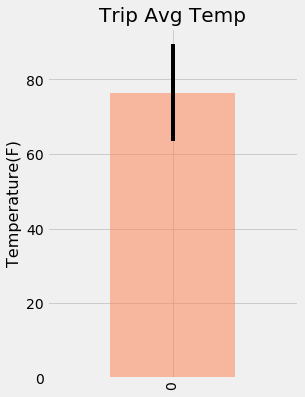

In [242]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)

trip_df = pd.DataFrame(trip_temps, columns=['Min Temp', 'Avg Temp', 'Max Temp'])
avg_temp = trip_df['Avg Temp']
min_max_temp = trip_df.iloc[0]['Max Temp'] - trip_df.iloc[0]['Min Temp']
avg_temp.plot(kind='bar', yerr=min_max_temp, figsize=(4,6), alpha=0.5, color='coral')

plt.title("Trip Avg Temp", fontsize=20)
plt.ylabel("Temperature(F)", fontsize=16)
plt.savefig("Graphs/Unit10-5.png")
plt.show()

### Daily Normal Temperature

Calculate the daily normals. Normals are the averages for the min, avg, and max temperatures.

You are provided with a function called daily_normals that will calculate the daily normals for a specific date. This date string will be in the format %m-%d. Be sure to use all historic TOBS that match that date string.

Create a list of dates for your trip in the format %m-%d. Use the daily_normals function to calculate the normals for each date string and append the results to a list.

In [157]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

[(62.0, 69.15384615384616, 77.0)]

In [165]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Use the start and end date to create a range of dates
trip_date_range = pd.date_range(Trip_Start_Date, Trip_End_Date)

# Stip off the year and save a list of %m-%d strings
trip_mmdd = trip_date_range.strftime('%m-%d')

# Loop through the list of %m-%d strings and calculate the normals for each date
normals_ls = []
for trip_date in trip_mmdd:
    #unpack with daily_normals function definition
    normals_ls.append(*daily_normals(trip_date))
    
# Load the previous query results into a Pandas DataFrame 
normals_df = pd.DataFrame(normals_ls, columns = ['Tmin', 'Tavg', 'Tmax'])

# add the `trip_dates` range as the `date` index
normals_df['date'] = trip_date_range
normals_df.set_index('date', inplace=True)  
normals_df = normals_df.iloc[:, ::-1]
normals_df.head(1)

,Tmax,Tavg,Tmin
date,,,
2021-10-15,82.0,75.634615,67.0


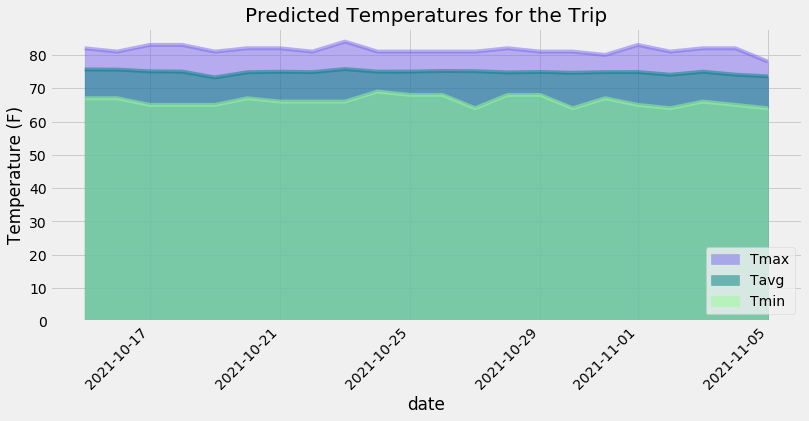

In [243]:
# Plot the daily normals as an area plot with `stacked=False`
#make a colors list
colors = ['mediumslateblue', 'teal', 'palegreen']

#make an area plot for the predicted temps
normals_df.plot(kind='area', figsize=(12, 6), stacked=False, x_compat=True, rot=45, color=colors, grid=True)

#make the labels
plt.ylabel('Temperature (F)')
plt.title("Predicted Temperatures for the Trip", fontsize=20)
plt.legend(loc='lower right')
plt.savefig("Graphs/Unit10-6.png")
plt.show()


### Daily Rainfall Average and Normal Temperature
Calculating the rainfall per weather station using the previous year's matching dates.


In [164]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
trip_prcp =   session.query(Measurement.station, func.sum(Measurement.prcp)).\
            group_by(Measurement.station).\
            filter(Measurement.date >= PrevYr_trip_start).filter(Measurement.date <= PrevYr_trip_end).\
            order_by(func.sum(Measurement.prcp).desc()).all()

trip_prcp_df = pd.DataFrame(trip_prcp, columns =['station', 'total rainfall']) 
trip_prcp_df = pd.merge(trip_prcp_df, station_df, how="left", on=["station", "station"])
trip_prcp_df 

,station,total rainfall,name,latitude,longitude,elevation
0,USC00516128,9.42,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4
1,USC00519281,1.24,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9
2,USC00513117,0.81,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6
3,USC00514830,0.75,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0
4,USC00517948,0.60,"PEARL CITY, HI US",21.39340,-157.97510,11.9
5,USC00519523,0.59,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5
6,USC00519397,0.52,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0


In [228]:
inspector = inspect(engine)
inspector.get_table_names()

['measurement', 'station']

In [233]:
same_station = session.query(Measurement.station, Station.station).\
                filter(Measurement.station == Station.station).all()